In [1]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
import numpy as np

ctx = mx.cpu()

In [2]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X,A) + b
Y = nd.ones(shape=(1000,1))

# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

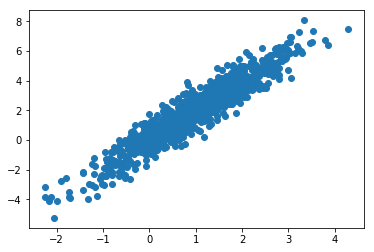

The covariance matrix is

[[ 5.          0.89999998]
 [ 0.89999998  0.25999999]]
<NDArray 2x2 @cpu(0)>


In [3]:

plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A, A.T))

In [4]:
# build the generator
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Dense(2))

# build the discriminator (with 5 and 3 hidden units respectively)
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Dense(5, activation='tanh'))
    netD.add(nn.Dense(3 ,activation='tanh'))
    netD.add(nn.Dense(2))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.05})

In [5]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time


binary training acc at epoch 0: accuracy=0.716500
time: 2.291495


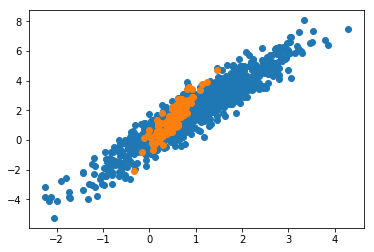


binary training acc at epoch 1: accuracy=0.593500
time: 2.482498


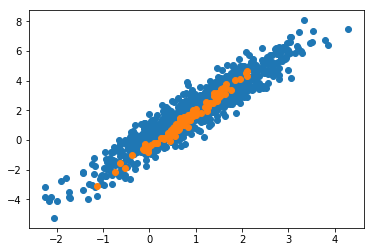


binary training acc at epoch 2: accuracy=0.488000
time: 2.276498


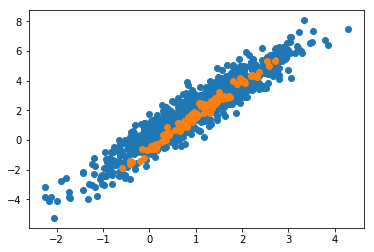


binary training acc at epoch 3: accuracy=0.499000
time: 2.621998


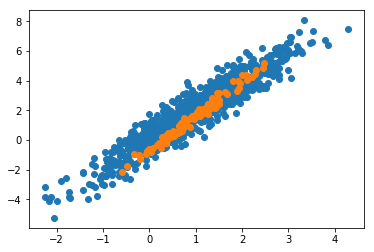


binary training acc at epoch 4: accuracy=0.496000
time: 2.729000


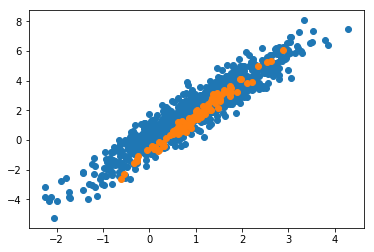


binary training acc at epoch 5: accuracy=0.516000
time: 2.551998


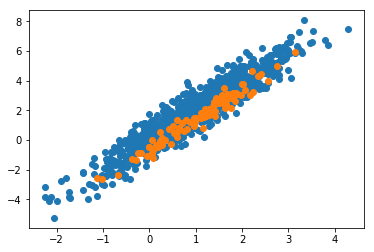


binary training acc at epoch 6: accuracy=0.505000
time: 2.659496


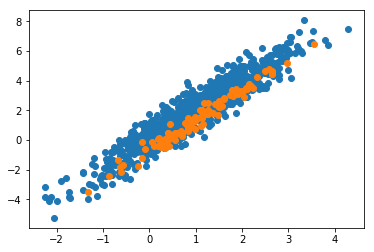


binary training acc at epoch 7: accuracy=0.502500
time: 2.552498


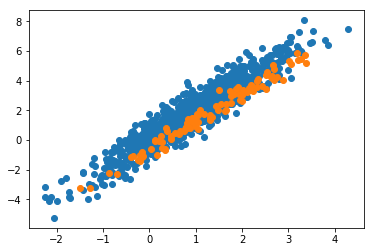


binary training acc at epoch 8: accuracy=0.494500
time: 2.508758


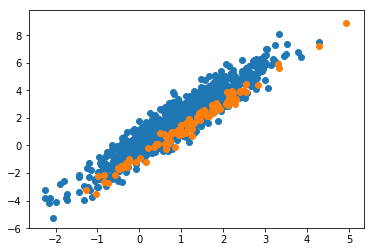


binary training acc at epoch 9: accuracy=0.496000
time: 2.534498


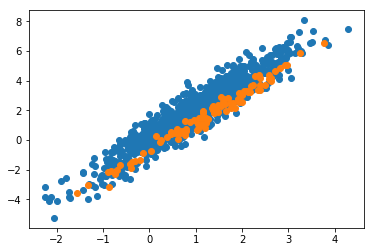

In [6]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(10):
    tic = time.time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real_t
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random_normal(shape=(batch_size, 2), ctx=ctx)

        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)

            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()

        trainerD.step(batch_size)
        metric.update([real_label,], [real_output,])
        metric.update([fake_label,], [fake_output,])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch_size)

    name, acc = metric.get()
    metric.reset()
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    noise = nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
    plt.scatter(fake[:,0].asnumpy(),fake[:,1].asnumpy())
    plt.show()